In [1]:
# Preamble
from astropy.table import Table, column, vstack
import numpy as np
import os
import pandas as pd

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

import sys
sys.path.append('../astro_codes/')

In [15]:
gz2_data = Table.read('../fits/full_sample_debiased_w_low_z_mod.fits')

In [40]:
arc_data = Table.read('panoptes_project/arc_table_ml.fits')
samples = Table.read('../fits/sparcfire/sparcfire_samples.fits')
mass_data = Table.read('../fits/Simard+Mendel/mendel_masses.fits')
sfr_data = Table.read('../fits/SF_fits/sfrs.fits')

#### First task: define the sample:

In [41]:
mask_columns = ('in_sparcfire_r','in_ml_dr7','in_spiral',
                'axial_ok')
in_ml_sample = np.all([samples[c] for c in mask_columns],axis=0)

print('{} galaxies were put in to sparcfire!'.format(in_ml_sample.sum()))
sample_ids = gz2_data['dr8objid'][in_ml_sample]

has_good_arcs = []
for id_ in sample_ids:
    arcs_id = arc_data[arc_data['gxyName'] == id_]
    has_good_arc = np.any(arcs_id['p_good_predicted'])
    has_good_arcs.append(has_good_arc)

has_good_arcs = np.array(has_good_arcs)
print('+ {} have good arcs identified by sparcfire!'.format(has_good_arcs.sum()))

5176 galaxies were put in to sparcfire!
+ 2688 have good arcs identified by sparcfire!


In [75]:
# First task: plot up the arm characteristics:
def get_gz2_stats(gz2_data):
    m_colnames = ['t11_arms_number_a31_1_debiased_rh',
                  't11_arms_number_a32_2_debiased_rh',
                  't11_arms_number_a33_3_debiased_rh',
                  't11_arms_number_a34_4_debiased_rh',
                  't11_arms_number_a36_more_than_4_debiased_rh']
    
    w_colnames = ['t10_arms_winding_a28_tight_debiased_rh',
                  't10_arms_winding_a29_medium_debiased_rh',
                  't10_arms_winding_a30_loose_debiased_rh']
    
    m_array = np.array([gz2_data[column] for column in m_colnames]).T
    w_array = np.array([gz2_data[column] for column in w_colnames]).T
    m = np.argmax(m_array,axis=1) + 1
    w = np.argmax(w_array,axis=1) + 1
    m_max = np.max(m_array,axis=1)
    w_max = np.max(w_array,axis=1)
    def measure_wtd_avg(array):
        N_rows, N_columns = np.shape(array)
        wtd_avg = np.zeros(N_rows)
        for c in range(N_columns):
            wtd_avg += array[:,c]*(c+1)
        wtd_avg_sum  = np.sum(array,axis=1)
        return wtd_avg/wtd_avg_sum
    m_wtd_avg = measure_wtd_avg(m_array)
    w_wtd_avg = measure_wtd_avg(w_array)
    p_bar = gz2_data['t03_bar_a06_bar_debiased_rh']
    return m, w, m_max, w_max ,m_wtd_avg, w_wtd_avg, p_bar


def measure_N_detected(ids,arc_data):
    N_detected = []
    pitch_angles = []
    for id_ in ids:
        arcs_id = arc_data[arc_data['gxyName'] == id_]
        N_detected_id = arcs_id['p_good_predicted'].sum()
        N_detected.append(N_detected_id)
        good_arcs = arcs_id['p_good_predicted'] == 1
        length_weights = arcs_id['arc_length'][good_arcs]
        Ps = arcs_id['pitch_angle_absolute'][good_arcs]
        if N_detected_id != 0:
            pitch_angle = np.average(Ps,weights=length_weights)
        else:
            pitch_angle = -999
        pitch_angles.append(pitch_angle)
    return N_detected, pitch_angles

m, w, m_max, w_max, m_wtd_avg, w_wtd_avg, p_bar = \
get_gz2_stats(gz2_data[in_ml_sample])
#N, P = measure_N_detected(sample_ids,arc_data)

galaxy_level_data = Table()
galaxy_level_data['id'] = sample_ids
galaxy_level_data['has_good_arc'] = has_good_arcs

galaxy_level_data['total_mass'] = mass_data[in_ml_sample]['bulge+disc']
galaxy_level_data['bulge_mass'] = mass_data[in_ml_sample]['bulge']
galaxy_level_data['disc_mass'] = mass_data[in_ml_sample]['disc']
galaxy_level_data['btr'] = 10**(mass_data[in_ml_sample]['bulge'] 
                              - mass_data[in_ml_sample]['bulge+disc'])

galaxy_level_data['m'] = m
galaxy_level_data['w'] = w
galaxy_level_data['N_sparcfire'] = N
galaxy_level_data['completeness'] = (galaxy_level_data['N_sparcfire']/
                                     galaxy_level_data['m'])
galaxy_level_data['P_wtd_avg'] = P
galaxy_level_data['w_wtd_avg'] = w_wtd_avg
galaxy_level_data['m_wtd_avg'] = m_wtd_avg
galaxy_level_data['m_max'] = m_max
galaxy_level_data['w_max'] = w_max
galaxy_level_data['p_bar'] = p_bar

galaxy_level_data['sfr_mpa'] = sfr_data['sfr_mpa'][in_ml_sample]
galaxy_level_data['sfr_fuv'] = sfr_data['sfr_fuv'][in_ml_sample]
galaxy_level_data['sfr_22'] = sfr_data['sfr_22'][in_ml_sample]
galaxy_level_data['sfr_total'] = sfr_data['sfr_total'][in_ml_sample]
galaxy_level_data['w4_ok'] = sfr_data['w4'][in_ml_sample] >= 2
galaxy_level_data['F_ok'] = sfr_data['F'][in_ml_sample] >= 2
galaxy_level_data['mir_fraction'] = sfr_data['mir_fraction'][in_ml_sample]

galaxy_level_data['has_bulge'] = np.isfinite(galaxy_level_data['bulge_mass'])
galaxy_level_data['has_disc'] = np.isfinite(galaxy_level_data['disc_mass'])

#print(galaxy_level_data['has_bulge'].sum(),len(galaxy_level_data['has_bulge']))
galaxy_level_data.write('galaxy_level_data.fits')

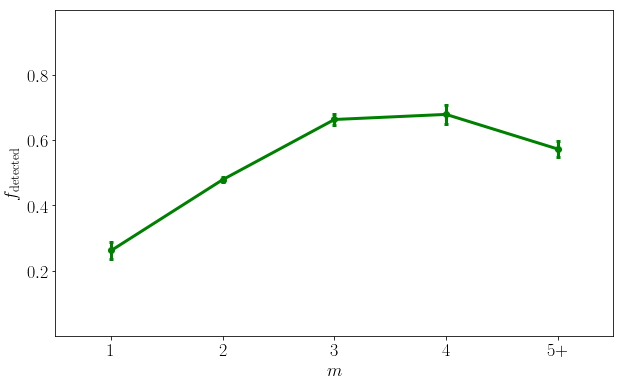

In [43]:
from bin_statistics import assign_bins, stats_functions
mlabels = ('1','2','3','4','5+')

f = stats_functions().fraction_with_feature(galaxy_level_data['has_good_arc'],
                                            galaxy_level_data['m'])

fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)

_ = ax.errorbar([1,2,3,4,5],f['f'],yerr=(f['f']-f['f-0.683']),color='g',
                marker='o',capsize=2,capthick=3,lw=3)

_ = ax.set_ylim(0,1)
_ = ax.set_xlim(0.5,5.5)
_ = ax.set_xticks([1,2,3,4,5])
_ = ax.set_xticklabels(mlabels)
_ = ax.set_xlabel('$m$')
_ = ax.set_ylabel('$f_\mathrm{detected}$')

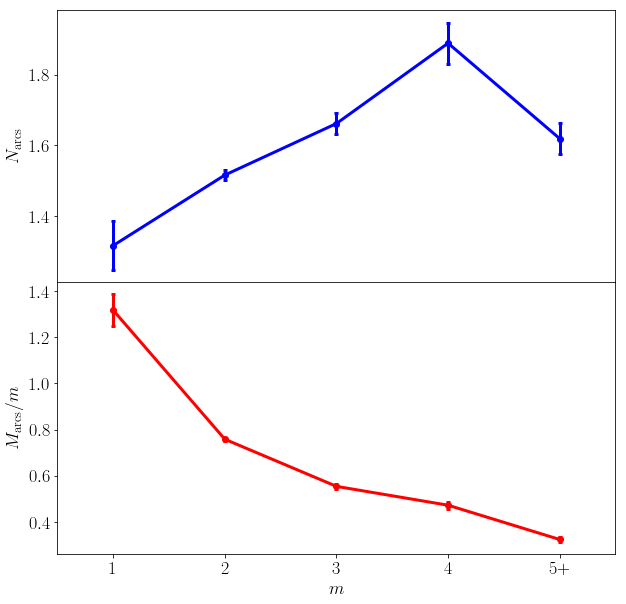

In [44]:
from xy_plots import x_vs_y

fig, axarr = plt.subplots(2,1,figsize=(10,10),sharex=True)
fig.subplots_adjust(hspace=0,wspace=0)
#ax = plt.subplot(111)

has_arc_mask = has_good_arcs

xy = x_vs_y(galaxy_level_data['m'][has_good_arcs],
            galaxy_level_data['N_sparcfire'][has_good_arcs])
xy.discrete_vs_continuous_binned(axarr[0],color='b',marker='o',
                                 capsize=2,capthick=3,lw=3)

xy = x_vs_y(galaxy_level_data['m'][has_good_arcs],
            galaxy_level_data['completeness'][has_good_arcs])
xy.discrete_vs_continuous_binned(axarr[1],color='r',marker='o',
                                 capsize=2,capthick=3,lw=3)

_ = axarr[1].set_xlim(0.5,5.5)
_ = axarr[1].set_xticks([1,2,3,4,5])
_ = axarr[1].set_xticklabels(mlabels)
_ = axarr[1].set_xlabel('$m$')
_ = axarr[0].set_ylabel('$N_\mathrm{arcs}$')
_ = axarr[1].set_ylabel('$M_\mathrm{arcs}/m$')

 **What we see here is that the new method is not particularly desirable for selecting the correct _number_ of arcs**
 
- We should, however, check how well it does at reproducing the pitch angles and other features?

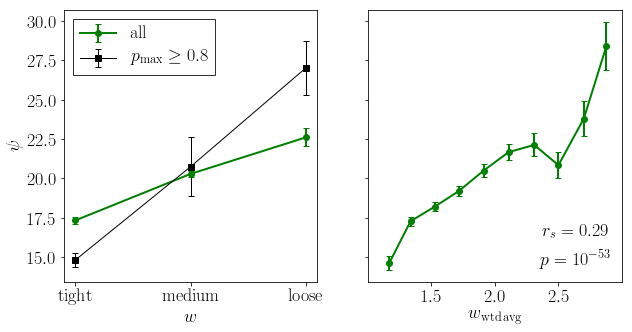

In [45]:
wlabels = ('tight','medium','loose')
fig, axarr = plt.subplots(1,2,figsize=(10,5),sharey=True)

########################
ax = axarr[0]

xy = x_vs_y(galaxy_level_data['w'][has_good_arcs],
            galaxy_level_data['P_wtd_avg'][has_good_arcs])
xy.discrete_vs_continuous_binned(ax,marker='o',color='g',lw=2,capsize=3,
                                 label='all')

best_w = (has_good_arcs*galaxy_level_data['w_max']) >= 0.8

xy = x_vs_y(galaxy_level_data['w'][best_w],
            galaxy_level_data['P_wtd_avg'][best_w])
xy.discrete_vs_continuous_binned(ax,marker='s',color='k',lw=1,capsize=3,
                                 label='$p_\mathrm{max} \geq 0.8$')

_ = ax.set_xlabel('$w$')
_ = ax.set_ylabel('$\psi$')
_ = ax.set_xticks([1,2,3])
_ = ax.set_xticklabels(wlabels)
_ = ax.legend(fancybox=False,edgecolor='k')
########################
ax = axarr[1]

xy = x_vs_y(galaxy_level_data['w_wtd_avg'][has_good_arcs],
            galaxy_level_data['P_wtd_avg'][has_good_arcs])
xy.continuous_vs_continuous_binned(ax,marker='o',color='g',lw=2,capsize=3)
xy.show_spearmanr(ax,location='lower right')

_ = ax.set_xlabel('$w_\mathrm{wtd \, avg}$')
_ = ax.set_xlim(1,3)

(1.5, 4.5)

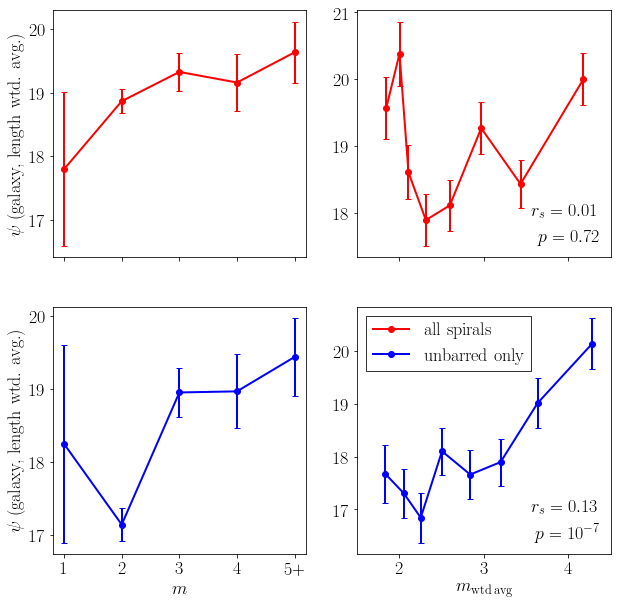

In [46]:
unbarred = (has_good_arcs*(galaxy_level_data['p_bar'] < 0.5)).astype(bool)

mlabels = ('1','2','3','4','5+')
fig, axarr = plt.subplots(2,2,figsize=(10,10),
                          sharex='col')

axarr = axarr.ravel()

################
ax = axarr[0]
xy = x_vs_y(galaxy_level_data['m'][has_good_arcs],
            galaxy_level_data['P_wtd_avg'][has_good_arcs])
xy.discrete_vs_continuous_binned(ax,marker='o',color='r',lw=2,capsize=3,
                                 label='all')

################
ax = axarr[1]
xy = x_vs_y(galaxy_level_data['m_wtd_avg'][has_good_arcs],
            galaxy_level_data['P_wtd_avg'][has_good_arcs])
xy.continuous_vs_continuous_binned(ax,bins=8,equal_N=True,
                                   marker='o',color='r',lw=2,capsize=3)
xy.show_spearmanr(ax,location='lower right')

################
ax = axarr[2]
xy = x_vs_y(galaxy_level_data['m'][unbarred],
            galaxy_level_data['P_wtd_avg'][unbarred])
xy.discrete_vs_continuous_binned(ax,marker='o',color='b',lw=2,capsize=3,label='all')

################
ax = axarr[3]
xy = x_vs_y(galaxy_level_data['m_wtd_avg'][unbarred],
            galaxy_level_data['P_wtd_avg'][unbarred])
xy.continuous_vs_continuous_binned(ax,bins=8,equal_N=True,label=None,
                                   marker='o',color='b',lw=2,capsize=3)
xy.show_spearmanr(ax,location='lower right')

axarr[0].set_ylabel('$\psi$ (galaxy, length wtd. avg.)')
axarr[1].set_xticks([1,2,3,4,5])
axarr[2].set_ylabel('$\psi$ (galaxy, length wtd. avg.)')
axarr[2].set_xlabel('$m$')
axarr[2].set_xticks([1,2,3,4,5])
axarr[2].set_xticklabels(mlabels)

axarr[3].set_xlabel('$m_\mathrm{wtd \, avg}$')
axarr[3].plot([],[],'ro-',lw=2,label='all spirals')
axarr[3].plot([],[],'bo-',lw=2,label='unbarred only')
axarr[3].legend(fancybox=False,edgecolor='k')
axarr[3].set_xticks([2,3,4])
axarr[3].set_xlim(1.5,4.5)

Here we see the result that we have seen before: there is a correlation between pitch angle and arm number: galaxies with _more spiral arms_ show _looser spiral structures_. The next stage will be to look at how arm numbers and pitch angles vary w.r.t bulge mass, disc mass and total mass.

#### Bar presence vs. pitch angle?

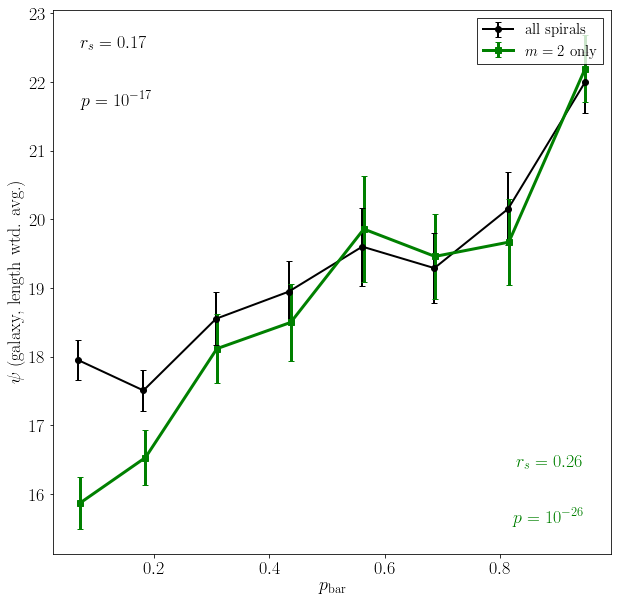

In [47]:
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

m_2 = (has_good_arcs*(galaxy_level_data['m'] == 2))

xy = x_vs_y(galaxy_level_data['p_bar'][has_good_arcs],
            galaxy_level_data['P_wtd_avg'][has_good_arcs])
xy.continuous_vs_continuous_binned(ax,marker='o',color='k',lw=2,capsize=3,
                                   label='all spirals',bins=8)
xy.show_spearmanr(ax,location='upper left')

xy = x_vs_y(galaxy_level_data['p_bar'][m_2],
            galaxy_level_data['P_wtd_avg'][m_2])
xy.continuous_vs_continuous_binned(ax,marker='s',color='g',lw=3,capsize=3,
                                   label='$m=2$ only',bins=8)
xy.show_spearmanr(ax,color='g',location='lower right')

_ = ax.legend(loc='upper right',fancybox=False,edgecolor='k',fontsize=15)
_ = ax.set_xlabel('$p_\mathrm{bar}$')
_ = ax.set_ylabel('$\psi$ (galaxy, length wtd. avg.)')

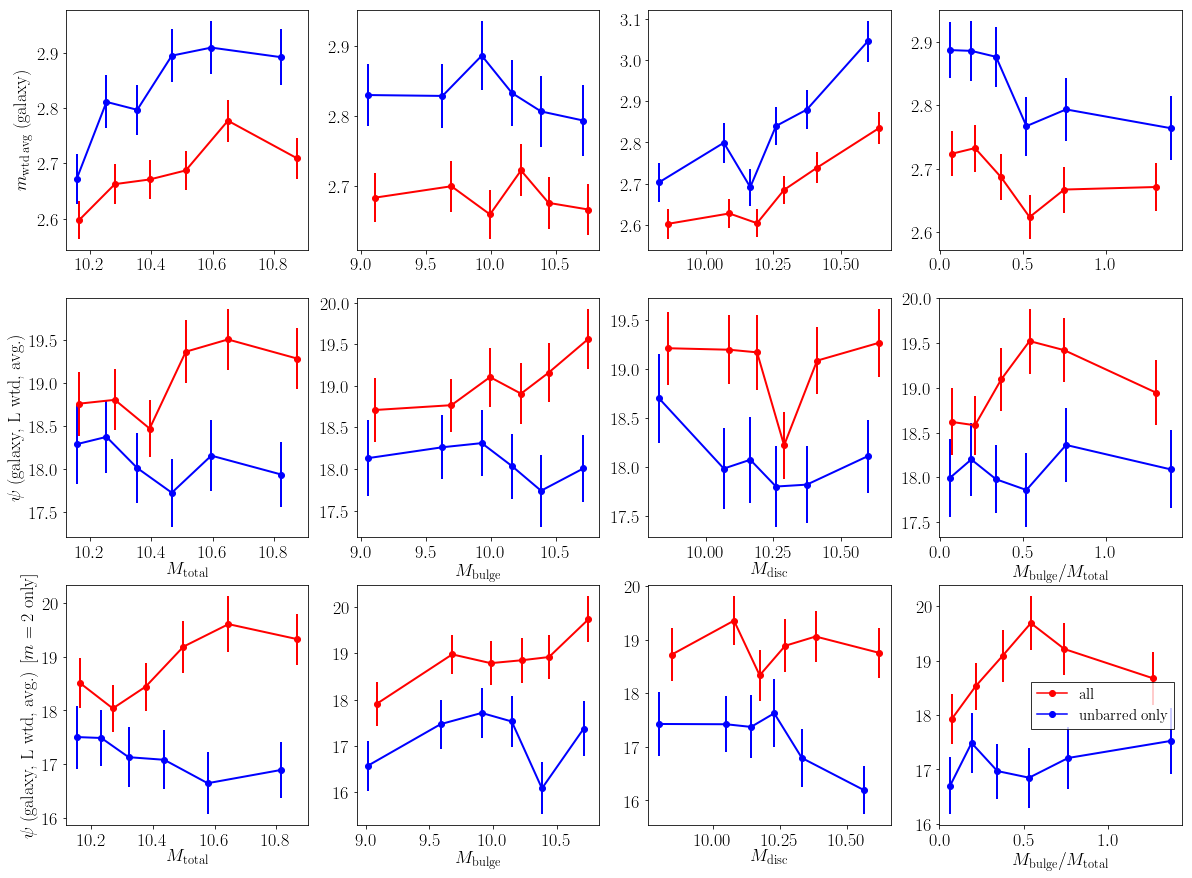

In [63]:
def xy_mass_row(axarr,table,y_column='m_wtd_avg',x_label=True,**kwargs):
    x_columns = ('total_mass','bulge_mass','disc_mass','btr')
    x_labels = ('$M_\mathrm{total}$','$M_\mathrm{bulge}$',
                '$M_\mathrm{disc}$','$M_\mathrm{bulge}/M_\mathrm{total}$')
    bulge_mask, disc_mask = table['has_bulge'],table['has_disc']
    masks = [(bulge_mask*disc_mask).astype(bool),bulge_mask,disc_mask,
             (bulge_mask*disc_mask).astype(bool)]
    for xlabel, x_column, ax, mask in zip(x_labels,x_columns,axarr,masks):
        xy = x_vs_y(table[x_column][mask],table[y_column][mask])
        xy.continuous_vs_continuous_binned(ax,bins=6,equal_N=True,**kwargs)
        if x_label is True:
            ax.set_xlabel(xlabel)
    return None

fig, axarr = plt.subplots(3,4,figsize=(20,15))
unbarred_m_2 = (unbarred*m_2).astype(bool)

xy_mass_row(axarr[0],galaxy_level_data[has_good_arcs],'m_wtd_avg',False,
            color='r',lw=2,marker='o')
xy_mass_row(axarr[0],galaxy_level_data[unbarred],'m_wtd_avg',False,
            color='b',lw=2,marker='o')

xy_mass_row(axarr[1],galaxy_level_data[has_good_arcs],'P_wtd_avg',False,
            color='r',lw=2,marker='o')
xy_mass_row(axarr[1],galaxy_level_data[unbarred],'P_wtd_avg',True,
            color='b',lw=2,marker='o')

xy_mass_row(axarr[2],galaxy_level_data[m_2],'P_wtd_avg',False,
            color='r',lw=2,marker='o',label=None)
xy_mass_row(axarr[2],galaxy_level_data[unbarred_m_2],'P_wtd_avg',True,
            color='b',lw=2,marker='o',label=None)

_ = axarr[0,0].set_ylabel('$m_\mathrm{wtd \, avg}$ (galaxy)')
_ = axarr[1,0].set_ylabel('$\psi$ (galaxy, L wtd, avg.)')
_ = axarr[2,0].set_ylabel('$\psi$ (galaxy, L wtd, avg.) [$m=2$ only]')
_ = axarr[-1,-1].plot([],[],'ro-',label='all')
_ = axarr[-1,-1].plot([],[],'bo-',label='unbarred only')
_ = axarr[-1,-1].legend(fancybox=False,edgecolor='k',fontsize=15)

**Finally, compare the SFRs?**

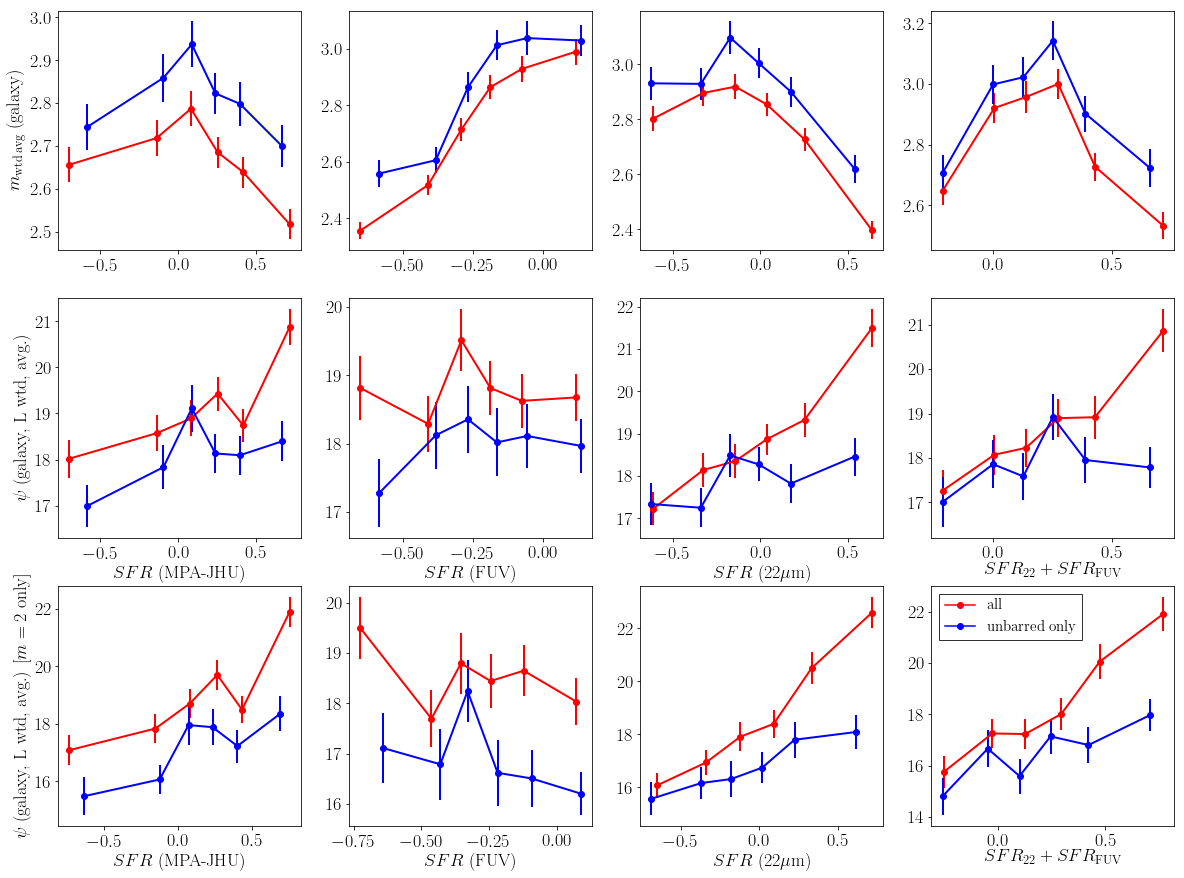

In [73]:
def xy_sfr_row(axarr,table,y_column='m_wtd_avg',x_label=True,**kwargs):
    x_columns = ('sfr_mpa','sfr_fuv','sfr_22','sfr_total')
    x_labels = ('$SFR$ (MPA-JHU)','$SFR$ (FUV)',
                '$SFR$ (22$\mu$m)','$SFR_{22} + SFR_\mathrm{FUV}$')
    masks = (table['sfr_mpa'] >= -10, table['F_ok'], table['w4_ok'],
             (table['F_ok']*table['w4_ok']).astype(bool))
    for xlabel, x_column, mask, ax in zip(x_labels,x_columns,masks,axarr):
        xy = x_vs_y(table[x_column][mask],table[y_column][mask])
        xy.continuous_vs_continuous_binned(ax,bins=6,equal_N=True,**kwargs)
        if x_label is True:
            ax.set_xlabel(xlabel)
    return None

fig, axarr = plt.subplots(3,4,figsize=(20,15))

xy_sfr_row(axarr[0],galaxy_level_data[has_good_arcs],'m_wtd_avg',False,
            color='r',lw=2,marker='o')
xy_sfr_row(axarr[0],galaxy_level_data[unbarred],'m_wtd_avg',False,
            color='b',lw=2,marker='o')

xy_sfr_row(axarr[1],galaxy_level_data[has_good_arcs],'P_wtd_avg',False,
            color='r',lw=2,marker='o')
xy_sfr_row(axarr[1],galaxy_level_data[unbarred],'P_wtd_avg',True,
            color='b',lw=2,marker='o',label=None)

xy_sfr_row(axarr[2],galaxy_level_data[m_2],'P_wtd_avg',False,
            color='r',lw=2,marker='o',label=None)
xy_sfr_row(axarr[2],galaxy_level_data[unbarred_m_2],'P_wtd_avg',True,
            color='b',lw=2,marker='o',label=None)

_ = axarr[0,0].set_ylabel('$m_\mathrm{wtd \, avg}$ (galaxy)')
_ = axarr[1,0].set_ylabel('$\psi$ (galaxy, L wtd, avg.)')
_ = axarr[2,0].set_ylabel('$\psi$ (galaxy, L wtd, avg.) [$m=2$ only]')
_ = axarr[-1,-1].plot([],[],'ro-',label='all')
_ = axarr[-1,-1].plot([],[],'bo-',label='unbarred only')
_ = axarr[-1,-1].legend(fancybox=False,edgecolor='k',fontsize=15)